#### Pokemon type clasiffication
Mihai Matei [Data Science]

To have a more common API and limit the size of the notebook I created the matmih utility package (see archive)

In [1]:
# Download some of the required libraries
import sys
def install_modules():
    !pip install --quiet kaggle
    !pip install --quiet randomcolor
    !pip install --quiet scikit-learn
    !pip install --quiet tensorflow-gpu
install_modules()

#### Download the Pokemon database
Create a kaggle account and an API token 
https://github.com/Kaggle/kaggle-api/blob/master/README.md

In [2]:
%load_ext autoreload
%autoreload
import sys
import os
import shutil

# Import my own library from local disk or gdrive
GDRIVE_PATH='/content/gdrive/My Drive/master/PractML/Project1/'
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append(GDRIVE_PATH)
    os.makedirs('/root/.kaggle/', exist_ok=True)
    shutil.copyfile(GDRIVE_PATH + 'kaggle.json', '/root/.kaggle/kaggle.json')
    !chmod 600 '/root/.kaggle/kaggle.json'

import matmih as mm

# Download the pokemon kaggle database
if not os.path.isfile('./data/pokemon.csv'):
    import kaggle
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('vishalsubbiah/pokemon-images-and-types', path='./data', unzip=True)

#### Pokemon data set
Load the Pokemon data set and all the images in the directory. Create a target column as a panda category type

In [3]:
import numpy as np
import pandas as pd

pDF = pd.read_csv('./data/pokemon.csv', delimiter=',')
pDF.dataframeName = 'pokemon.csv'

def load_images(df):
    imgUrls = df.apply(lambda row: './data/images/images/' + row['Name'].lower(), axis=1)
    df['ImageURL'] = imgUrls.apply(lambda row: row + '.png' if os.path.isfile(row + '.png') else row + '.jpg')

    df['target'] = df['Type1'].astype('category')
    df['features'] = df['ImageURL'].apply(lambda row: mm.Image.load(row, size=(128,128)))

    return df

pDF = load_images(pDF)
pDF.describe()

,Name,Type1,Type2,ImageURL,target,features
count,809,809,405,809,809,809
unique,809,18,18,809,18,809
top,togedemaru,Water,Flying,./data/images/images/clamperl.png,Water,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
freq,1,114,95,1,114,1


##### Pokemon Type histograms
Lets take a quick look at the dataset and the class distribution. Notice that some classes are predominant in Type I and others in Type II columns.

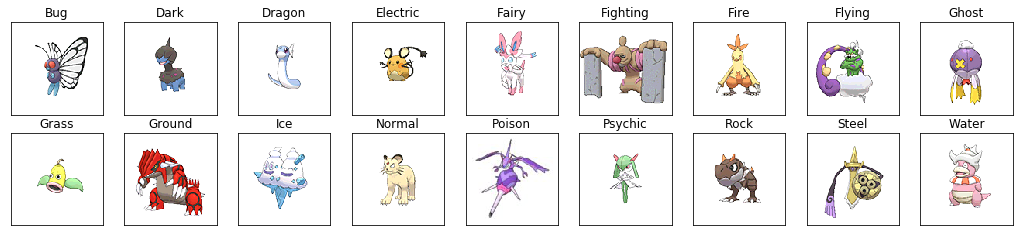

Pokemon class targets: ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']


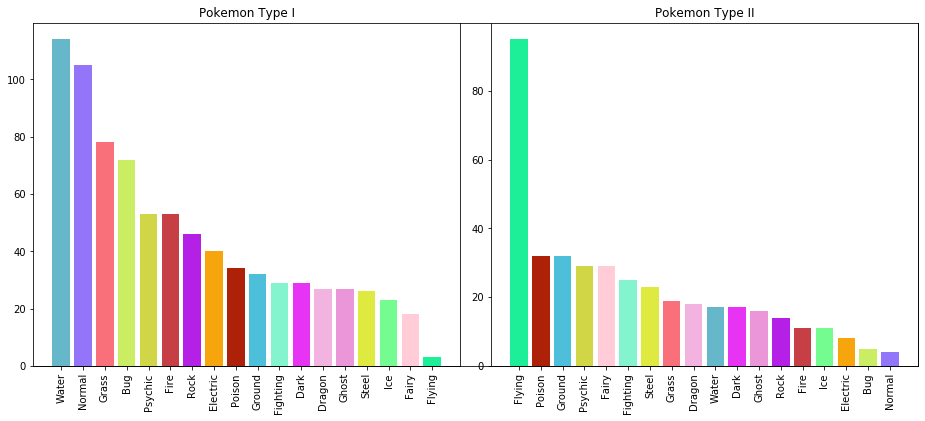

In [4]:
import random
from datetime import datetime
# Seed the pseudo random number generator
random.seed(datetime.now())

def show_random_pokemons(df):
    images = []
    titles = []
    # show a pokemon for each class
    for cl in df['target'].cat.categories:
        class_df = df[df['target'] == cl]
        idx = random.randrange(len(class_df))
        titles.append(class_df['Type1'].iloc[idx])
        images.append(class_df['ImageURL'].iloc[idx])

    mm.PlotBuilder().create_images(images, titles).show()

show_random_pokemons(pDF)

print("Pokemon class targets: {}".format(pDF['target'].cat.categories.to_list()))
mm.PlotBuilder().create_histograms([pDF['target'], pDF['Type2'].astype('category')],
                                   ['Pokemon Type I', 'Pokemon Type II']).show()

#### Pokemon type augmentation
To augment the dataset we also duplicate the Type II column as a new Type I entry that has the original image rotate by 20 degrees.

Do a 0.9, 0.05, 0.05 stratified split (preserving class distribution) to get the training/validation/test set.

Filter the Pokemon Names in the 3 sets to make sure that no Pokemon is found in either sets (e.g. Type I Pokemon found in train and Type II of the same Pokemon found in test)

Make sure there is at lest one pokemon class in validation and test set

Train size: 1012
Validation size: 61
Test size: 63


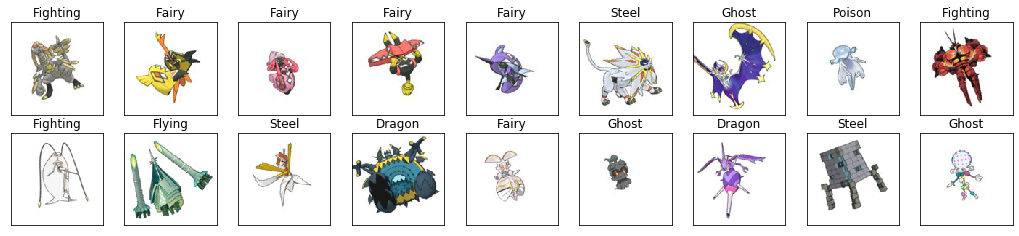

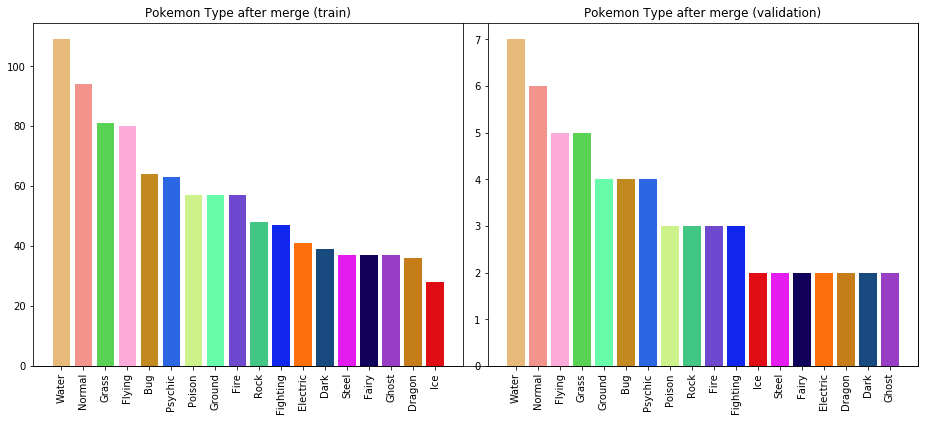

In [5]:
from scipy.ndimage.interpolation import rotate

# Create the dataset from the panda dataframe that will be used to create the test-validation split
data_set = mm.DataSet(pDF, feature_column='features', target_column='target')

# We are augmenting the dataset by adding the pokemons that have the second type set up as well
# We only do this for the ones that are from the training set
def add_second_type_pokemons(ds):
    type2_pok = ds[ds['Type2'].isnull() == False].copy()
    # rotate the feature images to createa a new feature set as well
    type2_pok['features'] = type2_pok['features'].apply(lambda image: rotate(image, angle=20, cval=255, reshape=False))
    # set Type2 as the new target class
    type2_pok['target'] = raw_cat = pd.Categorical(type2_pok['Type2'], categories=ds['target'].cat.categories)
    plot = mm.PlotBuilder().create_images(type2_pok['features'][-18:].values, type2_pok['target'][-18:].values)

    # append assigning new index to each new row in type2_pok
    return pd.concat([ds, type2_pok], ignore_index=True)

# Filter the 2 dataset so that they do not have entries with the same features
def filter_pokemons(to_filter_ds, test_ds):
    return to_filter_ds.drop(to_filter_ds[to_filter_ds['Name'].isin(test_ds['Name'])].index), test_ds

# Split and shuffle the data set so that the class distribution of the pokemons remain the same - stratisfied split
# Except for the test set that will not be stratisfied, to preserve randomness
# The validation set is forced to have at least one pokemon of each class
data_set.split_data((0.90, 0.05, 0.05), True, True, add_second_type_pokemons, filter_pokemons)

# check that there are no pokemons common between splits
assert not np.any(np.in1d(data_set.train_set['Name'].values, data_set.validation_set['Name'].values, assume_unique=True))
assert not np.any(np.in1d(data_set.validation_set['Name'].values, data_set.test_set['Name'].values, assume_unique=True))
assert not np.any(np.in1d(data_set.train_set['Name'].values, data_set.test_set['Name'].values, assume_unique=True))

print("Train size: {}".format(len(data_set.train_target)))
print("Validation size: {}".format(len(data_set.validation_target)))
print("Test size: {}".format(len(data_set.test_target)))
mm.PlotBuilder().create_histograms([data_set.train_target, data_set.validation_target],
                                   ['Pokemon Type after merge (train)', 'Pokemon Type after merge (validation)']).show()

#### Random model
The worst thing that can happen to a classification model is to have the same accuracy as the random selection according to either the class distribution or random as all.

Construct a random model that either selects uniformly random a target class or it selects it according to the probability of the class distribution.

In [6]:
from sklearn.metrics import accuracy_score
epochs = 1000
# Check the random classifier accuracy for the pokemon classes - should be 1/18 = 0.05555...
random_model = mm.RandomClassifier(epochs=epochs)
data_model = mm.ModelDataSet(data_set)

history = random_model.train(data_model, balanced=False)
test_acc = np.zeros((epochs,))
for i in range(epochs):
    test_target, _ = random_model.predict(data_model.test_features)
    test_acc[i] = accuracy_score(data_model.test_target, test_target, normalize=True)
print("Random multiclass classifier mean train accuracy: {0:.5f}".format(history['accuracy']))
print("Random multiclass classifier mean validation accuracy: {0:.5f}".format(history['val_accuracy']))
print("Random multiclass classifier mean test accuracy: {0:.5f}".format(np.mean(test_acc)))

history = random_model.train(mm.ModelDataSet(data_set), balanced=True)
for i in range(epochs):
    test_target, _ = random_model.predict(data_model.test_features)
    test_acc[i] = accuracy_score(data_model.test_target, test_target, normalize=True)
print("Random multiclass classifier using target class distribution mean train accuracy: {0:.5f}".format(history['accuracy']))
print("Random multiclass classifier using target class distribution mean validation accuracy: {0:.5f}".format(history['val_accuracy']))
print("Random multiclass classifier using target class distribution mean test accuracy: {0:.5f}".format(np.mean(test_acc)))

del(random_model)
del(history)
del(data_model)

Random multiclass classifier mean train accuracy: 0.05526
Random multiclass classifier mean validation accuracy: 0.05525
Random multiclass classifier mean test accuracy: 0.05543
Random multiclass classifier using target class distribution mean train accuracy: 0.06526
Random multiclass classifier using target class distribution mean validation accuracy: 0.06666
Random multiclass classifier using target class distribution mean test accuracy: 0.06786


#### Image generation
To augment our *train* dataset we generate sllightly altered images and add them to the train set.

The generated images are rotated, shifted, flipped.

Though a good CNN model should be invariant of those modifications we will test which one of the 2 data sets (augmented or not) are better.

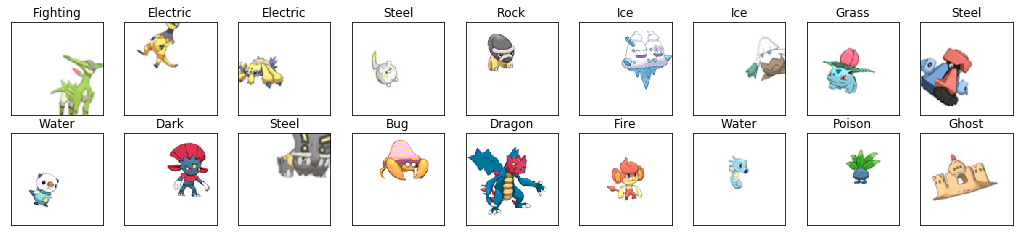

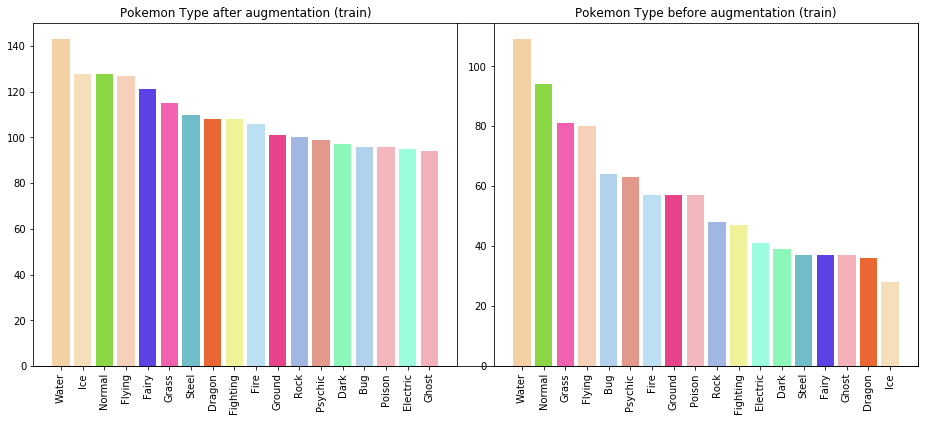

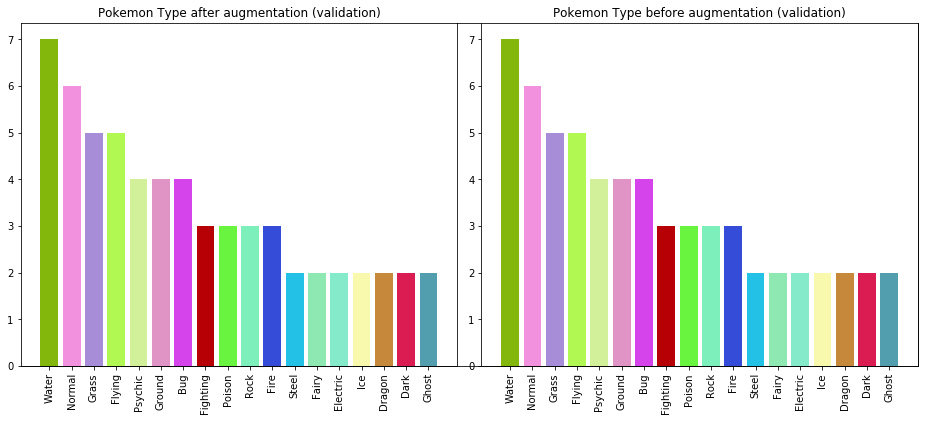

Train set size without image generation: 1012
Train set size with image generation: 1972


In [7]:
# We can augment our training data by generating modifed images and adding them to our training set
# We do this so to try to balance the current class distributions, by generating more images for unbalanced data
def augment_training_data(data_model, iterations):
    image_generator = mm.ImageGenerator(data_model, balanced=True,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        horizontal_flip=True)

    # augment the train dataset with the image generator
    for image_features, image_target in image_generator.generate(iterations):
        data_model.augment_train(image_features, image_target)

    return data_model
    
# Create the numpy dataset that we will use in the mm.Model classes
data_model = mm.ModelDataSet(data_set)

# Augment by adding modified images
data_model_aug = mm.ModelDataSet(data_set)
data_model_aug = augment_training_data(data_model_aug, iterations=30)

# Plot some of augmented images
plot = mm.PlotBuilder().create_images(data_model_aug.train_features[-18:],
                                      [data_set.classes[i] for i in data_model_aug.train_target[-18:]])
plot.create_histograms([(data_model_aug.train_target, data_set.classes), (data_model.train_target, data_set.classes)],
                       ['Pokemon Type after augmentation (train)', 'Pokemon Type before augmentation (train)'])
plot.create_histograms([(data_model_aug.validation_target, data_set.classes), (data_model.validation_target, data_set.classes)],
                       ['Pokemon Type after augmentation (validation)', 'Pokemon Type before augmentation (validation)']).show()

print("Train set size without image generation: {}".format(len(data_model.train_target)))
print("Train set size with image generation: {}".format(len(data_model_aug.train_target)))
# Normalize the features before proceeding
# This function is taken from the original tf repo. It ensures that all layers have a channel number that is divisible by 8
#  https://arxiv.org/abs/1801.04381
data_model = data_model.normalize_MobileNetV2()
data_model_aug = data_model_aug.normalize_MobileNetV2()

### CNN Model
Use transfer learning to create a CNN Model starting from MobileNetV2.

All the models extend the matmih.model.Model class.

Added a multitude of hyperparameters to be tried:
* denseSize - first dense layer size
* denseL2 - first dense layer L2 regularization
* dropoutRate - dropout layer percentage
* trainEpochs - number of epochs to train
* class_weights - if the target class distribution should be taken into account when computing the loss
* optimizer - the Keras optimizer to use (will also include parameters as learning rate)

In [8]:
import sklearn
import tensorflow as tf
keras = tf.keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

class CNNModel(mm.TensorModel):
    # Create the base model from the pre-trained model MobileNet V2
    _base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                                    include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')
    #_baseModel.trainable = False
    # Uncomment the below line to get a summary of the layers involved in MobilNetV2
    #_base_model.summary()
    BATCH_SIZE = 32

    def __init__(self, **hyper_params):
        model = tf.keras.Sequential([
                        CNNModel._base_model,
                        tf.keras.layers.Dense(hyper_params.get('denseSize', 128),
                                              kernel_initializer='glorot_uniform',
                                              kernel_regularizer=tf.keras.regularizers.l2(hyper_params.get('denseL2', 0.01)),
                                              bias_regularizer=tf.keras.regularizers.l2(hyper_params.get('denseL2', 0.01))),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Activation('relu'),
                        tf.keras.layers.Dropout(hyper_params.get('dropoutRate', 0.5)),
                        tf.keras.layers.Dense(hyper_params.get('noClasses', len(data_model.classes))),
                        tf.keras.layers.Activation('softmax')
                                              ])
        super(CNNModel, self).__init__(model)

        self._train_epochs = hyper_params.get('trainEpochs', 20)
        self._optimizer = hyper_params.get('optimizer', tf.keras.optimizers.RMSprop())
        self._class_weights = hyper_params.get('class_weights', False)

        # compile the model and initialize the weights
        self._model.compile(
             optimizer=self._optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(5)])

    # Convert the features/target np data to a tensorflow dataset
    @staticmethod
    def np_to_tf(features, target=None, batch_size=BATCH_SIZE):
        if target is None:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32)) )
        else:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32),
                                                      tf.cast(target, tf.int32)) )

        return ds if batch_size is None else ds.batch(batch_size)

    def train(self, data_model, logTensorBoard=False):
        # save the weights of the best epoch to disk
        callbacks = [tf.keras.callbacks.ModelCheckpoint(self.best_weights_path, monitor='val_accuracy',
                                                        verbose=0, save_best_only=True,
                                                        save_weights_only=True, mode='auto')]
        if logTensorBoard:
            callbacks += [tf.keras.callbacks.TensorBoard(mm.TensorBoard.get_log_dir(), histogram_freq=1)]

        train_ds = CNNModel.np_to_tf(data_model.train_features, data_model.train_target)
        validation_ds = CNNModel.np_to_tf(data_model.validation_features, data_model.validation_target)
        
        # compute the class weights to give to the model train target classes
        class_weights = None
        if self._class_weights:
            class_values = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                                           data_model.classes, data_model.train_target)
            class_values = class_values / np.min(class_values)
            class_weights = {c:class_values[c] for c in range(len(class_values))}

        history = self._model.fit(train_ds, validation_data=validation_ds,
                                  class_weight=class_weights,
                                  epochs=self._train_epochs, callbacks=callbacks)

        return history.history.copy()

    def predict(self, features):
        features_ds = tf.cast(features, tf.float32)
        return self._model.predict_classes(features_ds), self._model.predict(features_ds)

Num GPUs Available:  1


##### Hyper parameter space search
To check how our model works on different hyperparameters do a grid search using matmih.hyperparameters.HyperParamsLookup class.

After each model tried the tensorflow session is cleared. For the best model the weights are saved on disk

There are a total of 32 combinations that will be tried on the original dataset as well as the one augmented with the image generator.

In [9]:
# Search the hyperparameter space for the best model
cnnHyperLookup = mm.HyperParamsLookup(CNNModel(), lambda hist: np.max(hist['val_accuracy']))
cnnHyperLookup.grid_search(data_model, True,
                           noClasses=[len(data_model.classes)],
                           trainEpochs=[30],
                           denseSize=[128],
                           denseL2=[0.01],
                           dropoutRate=[0.4, 0.5],
                           class_weights=[True, False],
                           optimizer=[tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                      tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                                      tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2, nesterov=True),
                                      tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False)] )

cnnHyperLookupAug = mm.HyperParamsLookup(CNNModel(), lambda hist: np.max(hist['val_accuracy']))
cnnHyperLookupAug.grid_search(data_model_aug, True,
                           noClasses=[len(data_model.classes)],
                           trainEpochs=[30],
                           denseSize=[128],
                           denseL2=[0.01],
                           dropoutRate=[0.4, 0.5],
                           class_weights=[True, False],
                           optimizer=[tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                      tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                                      tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2, nesterov=True),
                                      tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False)] )

Epoch 1/30
32/32 [==============================] - 20s 613ms/step - loss: 5.3973 - accuracy: 0.1087 - sparse_top_k_categorical_accuracy: 0.4022 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/30
32/32 [==============================] - 3s 93ms/step - loss: 4.7303 - accuracy: 0.1542 - sparse_top_k_categorical_accuracy: 0.4862 - val_loss: 7.7979 - val_accuracy: 0.0656 - val_sparse_top_k_categorical_accuracy: 0.4262
Epoch 3/30
32/32 [==============================] - 3s 92ms/step - loss: 4.1165 - accuracy: 0.2164 - sparse_top_k_categorical_accuracy: 0.5791 - val_loss: 5.3043 - val_accuracy: 0.0984 - val_sparse_top_k_categorical_accuracy: 0.4098
Epoch 4/30
32/32 [==============================] - 3s 93ms/step - loss: 3.5869 - accuracy: 0.2678 - sparse_top_k_categorical_accuracy: 0.6650 - val_loss: 5.0352 - val_accuracy: 0.0984 - val_sparse_top_k_categorical_accuracy: 0.3770
Epoch 5/30
32/32 [==============================] - 3s

Epoch 5/30
32/32 [==============================] - 3s 92ms/step - loss: 2.0353 - accuracy: 0.9980 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 8.9298 - val_accuracy: 0.1148 - val_sparse_top_k_categorical_accuracy: 0.3607
Epoch 6/30
32/32 [==============================] - 3s 92ms/step - loss: 1.8424 - accuracy: 0.9990 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 8.4970 - val_accuracy: 0.0984 - val_sparse_top_k_categorical_accuracy: 0.3443
Epoch 7/30
32/32 [==============================] - 3s 92ms/step - loss: 1.6446 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 7.9740 - val_accuracy: 0.0984 - val_sparse_top_k_categorical_accuracy: 0.3279
Epoch 8/30
32/32 [==============================] - 3s 93ms/step - loss: 1.4515 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 7.2890 - val_accuracy: 0.1148 - val_sparse_top_k_categorical_accuracy: 0.3770
Epoch 9/30
32/32 [==============================] - 3s 92ms/step - l

Epoch 9/30
32/32 [==============================] - 3s 90ms/step - loss: 2.0870 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.2985 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.5410
Epoch 10/30
32/32 [==============================] - 3s 90ms/step - loss: 2.0465 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.2730 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.5082
Epoch 11/30
32/32 [==============================] - 3s 91ms/step - loss: 2.0096 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.2447 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5082
Epoch 12/30
32/32 [==============================] - 3s 90ms/step - loss: 1.9770 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.2210 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 13/30
32/32 [==============================] - 3s 96ms/step

Epoch 13/30
32/32 [==============================] - 3s 91ms/step - loss: 0.4761 - accuracy: 0.9130 - sparse_top_k_categorical_accuracy: 0.9911 - val_loss: 5.4480 - val_accuracy: 0.1475 - val_sparse_top_k_categorical_accuracy: 0.3607
Epoch 14/30
32/32 [==============================] - 3s 91ms/step - loss: 0.4391 - accuracy: 0.9249 - sparse_top_k_categorical_accuracy: 0.9921 - val_loss: 4.8679 - val_accuracy: 0.0984 - val_sparse_top_k_categorical_accuracy: 0.3279
Epoch 15/30
32/32 [==============================] - 3s 94ms/step - loss: 0.4285 - accuracy: 0.9229 - sparse_top_k_categorical_accuracy: 0.9960 - val_loss: 4.9944 - val_accuracy: 0.0984 - val_sparse_top_k_categorical_accuracy: 0.3770
Epoch 16/30
32/32 [==============================] - 3s 100ms/step - loss: 0.4117 - accuracy: 0.9239 - sparse_top_k_categorical_accuracy: 0.9951 - val_loss: 13.3561 - val_accuracy: 0.0656 - val_sparse_top_k_categorical_accuracy: 0.2951
Epoch 17/30
32/32 [==============================] - 3s 94ms/s

Epoch 17/30
32/32 [==============================] - 3s 96ms/step - loss: 0.1829 - accuracy: 0.9713 - sparse_top_k_categorical_accuracy: 0.9990 - val_loss: 11.0447 - val_accuracy: 0.0984 - val_sparse_top_k_categorical_accuracy: 0.3443
Epoch 18/30
32/32 [==============================] - 3s 92ms/step - loss: 0.2295 - accuracy: 0.9664 - sparse_top_k_categorical_accuracy: 0.9931 - val_loss: 12.3949 - val_accuracy: 0.0820 - val_sparse_top_k_categorical_accuracy: 0.3443
Epoch 19/30
32/32 [==============================] - 3s 93ms/step - loss: 0.2131 - accuracy: 0.9625 - sparse_top_k_categorical_accuracy: 0.9960 - val_loss: 11.0559 - val_accuracy: 0.1148 - val_sparse_top_k_categorical_accuracy: 0.3934
Epoch 20/30
32/32 [==============================] - 3s 93ms/step - loss: 0.2116 - accuracy: 0.9733 - sparse_top_k_categorical_accuracy: 0.9960 - val_loss: 20.1064 - val_accuracy: 0.0984 - val_sparse_top_k_categorical_accuracy: 0.3607
Epoch 21/30
32/32 [==============================] - 3s 92ms

Epoch 21/30
32/32 [==============================] - 3s 101ms/step - loss: 0.1085 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.1331 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.6393
Epoch 22/30
32/32 [==============================] - 3s 92ms/step - loss: 0.0873 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.1987 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5410
Epoch 23/30
32/32 [==============================] - 3s 93ms/step - loss: 0.0712 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.3022 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.5738
Epoch 24/30
32/32 [==============================] - 3s 92ms/step - loss: 0.0575 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.1839 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.6066
Epoch 25/30
32/32 [==============================] - 3s 94ms/st

Epoch 25/30
32/32 [==============================] - 3s 89ms/step - loss: 1.5997 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.3710 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.7049
Epoch 26/30
32/32 [==============================] - 3s 89ms/step - loss: 1.5733 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.3490 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.7049
Epoch 27/30
32/32 [==============================] - 3s 89ms/step - loss: 1.5472 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.3259 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.7213
Epoch 28/30
32/32 [==============================] - 3s 89ms/step - loss: 1.5243 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.3091 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.7049
Epoch 29/30
32/32 [==============================] - 3s 89ms/ste

Epoch 29/30
32/32 [==============================] - 3s 95ms/step - loss: 0.0197 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 2.7322 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.6393
Epoch 30/30
32/32 [==============================] - 3s 91ms/step - loss: 0.0098 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 2.7247 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.7049
Hyperparameters: {'noClasses': 18, 'trainEpochs': 30, 'denseSize': 128, 'denseL2': 0.01, 'dropoutRate': 0.4, 'class_weights': False, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000002001A070688>}
Results: 0.3442623019218445
Epoch 1/30
32/32 [==============================] - 17s 534ms/step - loss: 2.1008 - accuracy: 0.9536 - sparse_top_k_categorical_accuracy: 0.9792 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/30
32/32 [==============

Epoch 2/30
32/32 [==============================] - 3s 96ms/step - loss: 2.8836 - accuracy: 0.8972 - sparse_top_k_categorical_accuracy: 0.9891 - val_loss: 5.3007 - val_accuracy: 0.1475 - val_sparse_top_k_categorical_accuracy: 0.4590
Epoch 3/30
32/32 [==============================] - 4s 116ms/step - loss: 2.4496 - accuracy: 0.9852 - sparse_top_k_categorical_accuracy: 0.9990 - val_loss: 5.2983 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 4/30
32/32 [==============================] - 3s 105ms/step - loss: 2.2037 - accuracy: 0.9990 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.2198 - val_accuracy: 0.1803 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 5/30
32/32 [==============================] - 4s 111ms/step - loss: 1.9946 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.1313 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 6/30
32/32 [==============================] - 3s 106ms/step

Epoch 6/30
32/32 [==============================] - 3s 96ms/step - loss: 2.2323 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.0658 - val_accuracy: 0.2951 - val_sparse_top_k_categorical_accuracy: 0.5738
Epoch 7/30
32/32 [==============================] - 3s 88ms/step - loss: 2.1789 - accuracy: 0.9990 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.0539 - val_accuracy: 0.2951 - val_sparse_top_k_categorical_accuracy: 0.5738
Epoch 8/30
32/32 [==============================] - 3s 91ms/step - loss: 2.1377 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.0212 - val_accuracy: 0.2951 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 9/30
32/32 [==============================] - 3s 96ms/step - loss: 2.0975 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.0099 - val_accuracy: 0.3115 - val_sparse_top_k_categorical_accuracy: 0.6066
Epoch 10/30
32/32 [==============================] - 3s 87ms/step - 

Epoch 10/30
32/32 [==============================] - 3s 89ms/step - loss: 0.0559 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.6780 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.4918
Epoch 11/30
32/32 [==============================] - 3s 90ms/step - loss: 0.0479 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.6221 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 12/30
32/32 [==============================] - 3s 89ms/step - loss: 0.0318 - accuracy: 0.9990 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.3742 - val_accuracy: 0.1803 - val_sparse_top_k_categorical_accuracy: 0.6066
Epoch 13/30
32/32 [==============================] - 3s 88ms/step - loss: 0.0573 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.3817 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.5082
Epoch 14/30
32/32 [==============================] - 3s 89ms/ste

Epoch 14/30
32/32 [==============================] - 3s 93ms/step - loss: 0.1834 - accuracy: 0.9792 - sparse_top_k_categorical_accuracy: 0.9980 - val_loss: 3.7860 - val_accuracy: 0.0984 - val_sparse_top_k_categorical_accuracy: 0.3279
Epoch 15/30
32/32 [==============================] - 3s 93ms/step - loss: 0.2163 - accuracy: 0.9615 - sparse_top_k_categorical_accuracy: 0.9960 - val_loss: 4.3909 - val_accuracy: 0.1311 - val_sparse_top_k_categorical_accuracy: 0.3279
Epoch 16/30
32/32 [==============================] - 3s 98ms/step - loss: 0.1934 - accuracy: 0.9733 - sparse_top_k_categorical_accuracy: 0.9980 - val_loss: 4.1869 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.4426
Epoch 17/30
32/32 [==============================] - 3s 93ms/step - loss: 0.1924 - accuracy: 0.9634 - sparse_top_k_categorical_accuracy: 0.9951 - val_loss: 4.1214 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.4590
Epoch 18/30
32/32 [==============================] - 3s 94ms/ste

Epoch 18/30
32/32 [==============================] - 3s 102ms/step - loss: 0.3137 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.1550 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5574
Epoch 19/30
32/32 [==============================] - 3s 109ms/step - loss: 0.2661 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.1387 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 20/30
32/32 [==============================] - 4s 121ms/step - loss: 0.2252 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.1593 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5410
Epoch 21/30
32/32 [==============================] - 3s 106ms/step - loss: 0.1912 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.1718 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5410
Epoch 22/30
32/32 [==============================] - 3s 106m

Epoch 22/30
32/32 [==============================] - 3s 91ms/step - loss: 1.6909 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.8398 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 23/30
32/32 [==============================] - 3s 91ms/step - loss: 1.6653 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.8232 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.6066
Epoch 24/30
32/32 [==============================] - 3s 91ms/step - loss: 1.6386 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.8122 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 25/30
32/32 [==============================] - 3s 91ms/step - loss: 1.6081 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.8077 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.6066
Epoch 26/30
32/32 [==============================] - 3s 91ms/ste

Epoch 26/30
32/32 [==============================] - 3s 90ms/step - loss: 0.0315 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.6008 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 27/30
32/32 [==============================] - 3s 90ms/step - loss: 0.0206 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.2074 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 28/30
32/32 [==============================] - 3s 90ms/step - loss: 0.0161 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.7902 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.5082
Epoch 29/30
32/32 [==============================] - 3s 90ms/step - loss: 0.0179 - accuracy: 0.9990 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.1499 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 30/30
32/32 [==============================] - 3s 89ms/ste

Epoch 30/30
62/62 [==============================] - 6s 89ms/step - loss: 0.1544 - accuracy: 0.9792 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 10.1462 - val_accuracy: 0.0492 - val_sparse_top_k_categorical_accuracy: 0.3279
Hyperparameters: {'noClasses': 18, 'trainEpochs': 30, 'denseSize': 128, 'denseL2': 0.01, 'dropoutRate': 0.4, 'class_weights': True, 'optimizer': <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000002001A0703C8>}
Results: 0.24590164422988892
Epoch 1/30
62/62 [==============================] - 21s 345ms/step - loss: 3.8111 - accuracy: 0.6019 - sparse_top_k_categorical_accuracy: 0.8372 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/30
62/62 [==============================] - 6s 92ms/step - loss: 2.3243 - accuracy: 0.9838 - sparse_top_k_categorical_accuracy: 0.9990 - val_loss: 5.1623 - val_accuracy: 0.1311 - val_sparse_top_k_categorical_accuracy: 0.4262
Epoch 3/30
62/62 [========

Epoch 3/30
62/62 [==============================] - 5s 86ms/step - loss: 2.2454 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.3038 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.4918
Epoch 4/30
62/62 [==============================] - 5s 85ms/step - loss: 2.1579 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.2924 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.4754
Epoch 5/30
62/62 [==============================] - 5s 85ms/step - loss: 2.0863 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.2725 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.4918
Epoch 6/30
62/62 [==============================] - 5s 85ms/step - loss: 2.0159 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.2382 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.4918
Epoch 7/30
62/62 [==============================] - 5s 86ms/step - l

Epoch 7/30
62/62 [==============================] - 5s 86ms/step - loss: 0.1928 - accuracy: 0.9792 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 6.0021 - val_accuracy: 0.0820 - val_sparse_top_k_categorical_accuracy: 0.3279
Epoch 8/30
62/62 [==============================] - 5s 86ms/step - loss: 0.1607 - accuracy: 0.9843 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 6.4466 - val_accuracy: 0.0820 - val_sparse_top_k_categorical_accuracy: 0.3115
Epoch 9/30
62/62 [==============================] - 5s 86ms/step - loss: 0.1210 - accuracy: 0.9914 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 5.9564 - val_accuracy: 0.0820 - val_sparse_top_k_categorical_accuracy: 0.3115
Epoch 10/30
62/62 [==============================] - 5s 86ms/step - loss: 0.1097 - accuracy: 0.9873 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 8.2903 - val_accuracy: 0.0492 - val_sparse_top_k_categorical_accuracy: 0.2787
Epoch 11/30
62/62 [==============================] - 5s 86ms/step -

Epoch 11/30
62/62 [==============================] - 6s 89ms/step - loss: 0.0517 - accuracy: 0.9929 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 8.9933 - val_accuracy: 0.0492 - val_sparse_top_k_categorical_accuracy: 0.2951
Epoch 12/30
62/62 [==============================] - 6s 92ms/step - loss: 0.0684 - accuracy: 0.9883 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 5.7358 - val_accuracy: 0.1639 - val_sparse_top_k_categorical_accuracy: 0.3279
Epoch 13/30
62/62 [==============================] - 6s 89ms/step - loss: 0.1009 - accuracy: 0.9863 - sparse_top_k_categorical_accuracy: 0.9985 - val_loss: 7.7886 - val_accuracy: 0.0820 - val_sparse_top_k_categorical_accuracy: 0.3115
Epoch 14/30
62/62 [==============================] - 6s 90ms/step - loss: 0.0560 - accuracy: 0.9934 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 7.5222 - val_accuracy: 0.1639 - val_sparse_top_k_categorical_accuracy: 0.4590
Epoch 15/30
62/62 [==============================] - 6s 89ms/ste

Epoch 15/30
62/62 [==============================] - 6s 89ms/step - loss: 0.0404 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.5147 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.5738
Epoch 16/30
62/62 [==============================] - 6s 99ms/step - loss: 0.0314 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.5609 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 17/30
62/62 [==============================] - 6s 93ms/step - loss: 0.0238 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.8012 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 18/30
62/62 [==============================] - 6s 99ms/step - loss: 0.0188 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.8784 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 19/30
62/62 [==============================] - 6s 101ms/st

Epoch 19/30
62/62 [==============================] - 5s 87ms/step - loss: 1.3294 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.8250 - val_accuracy: 0.1803 - val_sparse_top_k_categorical_accuracy: 0.4918
Epoch 20/30
62/62 [==============================] - 6s 89ms/step - loss: 1.2900 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.8105 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.5082
Epoch 21/30
62/62 [==============================] - 6s 90ms/step - loss: 1.2493 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.7837 - val_accuracy: 0.1803 - val_sparse_top_k_categorical_accuracy: 0.4918
Epoch 22/30
62/62 [==============================] - 5s 88ms/step - loss: 1.2119 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.7657 - val_accuracy: 0.1803 - val_sparse_top_k_categorical_accuracy: 0.4918
Epoch 23/30
62/62 [==============================] - 5s 88ms/ste

Epoch 23/30
62/62 [==============================] - 6s 89ms/step - loss: 0.0258 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.9531 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 24/30
62/62 [==============================] - 6s 91ms/step - loss: 0.0114 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.6843 - val_accuracy: 0.1803 - val_sparse_top_k_categorical_accuracy: 0.5410
Epoch 25/30
62/62 [==============================] - 6s 95ms/step - loss: 0.0117 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.9406 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.5410
Epoch 26/30
62/62 [==============================] - 6s 96ms/step - loss: 0.0088 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.0296 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 27/30
62/62 [==============================] - 6s 89ms/ste

Epoch 27/30
62/62 [==============================] - 6s 90ms/step - loss: 0.0684 - accuracy: 0.9904 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 13.7786 - val_accuracy: 0.0656 - val_sparse_top_k_categorical_accuracy: 0.4262
Epoch 28/30
62/62 [==============================] - 6s 91ms/step - loss: 0.0746 - accuracy: 0.9914 - sparse_top_k_categorical_accuracy: 0.9985 - val_loss: 12.1024 - val_accuracy: 0.0492 - val_sparse_top_k_categorical_accuracy: 0.4426
Epoch 29/30
62/62 [==============================] - 6s 89ms/step - loss: 0.0760 - accuracy: 0.9873 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 11.3231 - val_accuracy: 0.0492 - val_sparse_top_k_categorical_accuracy: 0.4590
Epoch 30/30
62/62 [==============================] - 6s 91ms/step - loss: 0.0662 - accuracy: 0.9888 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 11.4584 - val_accuracy: 0.0492 - val_sparse_top_k_categorical_accuracy: 0.3770
Hyperparameters: {'noClasses': 18, 'trainEpochs': 30, 'dense

Hyperparameters: {'noClasses': 18, 'trainEpochs': 30, 'denseSize': 128, 'denseL2': 0.01, 'dropoutRate': 0.5, 'class_weights': True, 'optimizer': <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000002021F683D08>}
Results: 0.31147539615631104
Epoch 1/30
62/62 [==============================] - 15s 237ms/step - loss: 3.0587 - accuracy: 0.8631 - sparse_top_k_categorical_accuracy: 0.9391 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/30
62/62 [==============================] - 6s 91ms/step - loss: 2.3887 - accuracy: 0.9985 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.8411 - val_accuracy: 0.2951 - val_sparse_top_k_categorical_accuracy: 0.5246
Epoch 3/30
62/62 [==============================] - 6s 89ms/step - loss: 2.2585 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.8387 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.5082
Epoch 4/30
62/62 [==========

Epoch 4/30
62/62 [==============================] - 6s 89ms/step - loss: 0.0487 - accuracy: 0.9995 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.1295 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5082
Epoch 5/30
62/62 [==============================] - 6s 90ms/step - loss: 0.0442 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.1815 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5574
Epoch 6/30
62/62 [==============================] - 5s 89ms/step - loss: 0.0251 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.3635 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5574
Epoch 7/30
62/62 [==============================] - 5s 88ms/step - loss: 0.0245 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.6113 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5410
Epoch 8/30
62/62 [==============================] - 6s 90ms/step - l

Epoch 8/30
62/62 [==============================] - 6s 91ms/step - loss: 0.0378 - accuracy: 0.9970 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.0418 - val_accuracy: 0.1803 - val_sparse_top_k_categorical_accuracy: 0.4918
Epoch 9/30
62/62 [==============================] - 6s 90ms/step - loss: 0.0388 - accuracy: 0.9949 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 5.7270 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.4262
Epoch 10/30
62/62 [==============================] - 6s 91ms/step - loss: 0.0361 - accuracy: 0.9954 - sparse_top_k_categorical_accuracy: 0.9995 - val_loss: 5.3812 - val_accuracy: 0.1967 - val_sparse_top_k_categorical_accuracy: 0.3770
Epoch 11/30
62/62 [==============================] - 6s 91ms/step - loss: 0.0495 - accuracy: 0.9929 - sparse_top_k_categorical_accuracy: 0.9990 - val_loss: 5.9238 - val_accuracy: 0.1148 - val_sparse_top_k_categorical_accuracy: 0.4098
Epoch 12/30
62/62 [==============================] - 6s 91ms/step 

Epoch 12/30
62/62 [==============================] - 6s 91ms/step - loss: 0.1238 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.0743 - val_accuracy: 0.2131 - val_sparse_top_k_categorical_accuracy: 0.6393
Epoch 13/30
62/62 [==============================] - 6s 95ms/step - loss: 0.1002 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.0103 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.6393
Epoch 14/30
62/62 [==============================] - 6s 92ms/step - loss: 0.0808 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.0045 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 15/30
62/62 [==============================] - 6s 91ms/step - loss: 0.0679 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.0601 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5902
Epoch 16/30
62/62 [==============================] - 6s 91ms/ste

Epoch 16/30
62/62 [==============================] - 5s 88ms/step - loss: 1.4690 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.4013 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5574
Epoch 17/30
62/62 [==============================] - 5s 86ms/step - loss: 1.4220 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.3686 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5574
Epoch 18/30
62/62 [==============================] - 5s 86ms/step - loss: 1.3775 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.3385 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5738
Epoch 19/30
62/62 [==============================] - 5s 87ms/step - loss: 1.3375 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.3149 - val_accuracy: 0.2459 - val_sparse_top_k_categorical_accuracy: 0.5738
Epoch 20/30
62/62 [==============================] - 5s 86ms/ste

Epoch 20/30
62/62 [==============================] - 5s 88ms/step - loss: 0.0136 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.5247 - val_accuracy: 0.2295 - val_sparse_top_k_categorical_accuracy: 0.6557
Epoch 21/30
62/62 [==============================] - 5s 88ms/step - loss: 0.0193 - accuracy: 0.9995 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.4128 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.5410
Epoch 22/30
62/62 [==============================] - 5s 88ms/step - loss: 0.0267 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.7196 - val_accuracy: 0.2787 - val_sparse_top_k_categorical_accuracy: 0.4754
Epoch 23/30
62/62 [==============================] - 5s 88ms/step - loss: 0.0252 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 4.4690 - val_accuracy: 0.2623 - val_sparse_top_k_categorical_accuracy: 0.5574
Epoch 24/30
62/62 [==============================] - 5s 88ms/ste

##### Hyper parameter search model results
Plot the results of the hyperparameter model search.

The plots will contain the same color for the same model. The train metrics are ploted using dotted lines.

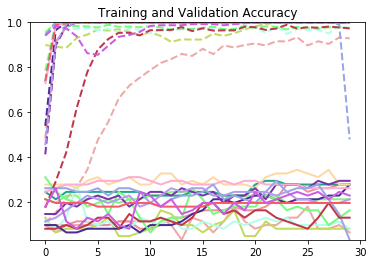

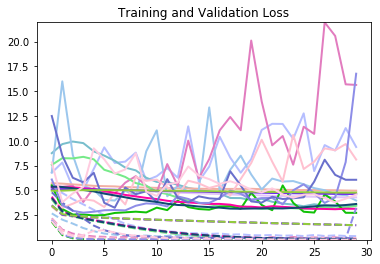

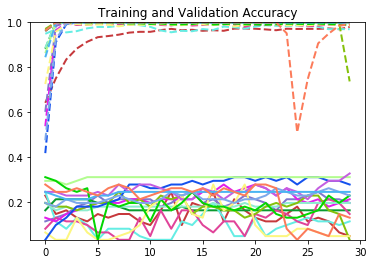

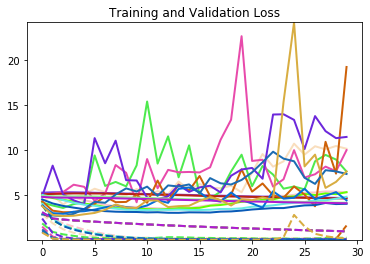

In [10]:
# Show a per epoch training history
def showTrainingHistory(histories, plot_loss=True, plot_top5 = False, scatter = False):
    train_acc = []
    val_acc = []
    val_acc5 = []
    train_loss = []
    val_loss = []
    for hyper_params, history in histories:
        train_acc.append(history['accuracy'])
        val_acc.append(history['val_accuracy'])
        train_loss.append(history['loss'])
        val_loss.append(history['val_loss'])
        if plot_top5:
            val_acc5.append(history['val_sparse_top_k_categorical_accuracy'])

    epoch = range(len(train_acc[0]))
    pb = mm.PlotBuilder()
    pb._plot_scatter = scatter
    if len(train_acc) == 1:
        y_vals = [(train_acc[0], 'Training Accuracy'), (val_acc[0], 'Validation Accuracy')]
        if plot_top5:
            y_vals.append((val_acc5[0], 'Validation top 5 accuracy'))
        pb.create_plot('Training and Validation Accuracy', (epoch, 'epoch'), *y_vals)
        if plot_loss:
            pb.create_plot('Training and Validation Loss', (epoch, 'epoch'),
                           (train_loss[0], 'Training Loss'), (val_loss[0], 'Validation Loss'))
            
    else:
        pb.create_plot('Training and Validation Accuracy', (epoch, 'epoch'),
                       *[[u, v] for u,v in zip(train_acc, val_acc)])
        if plot_loss:
            pb.create_plot('Training and Validation Loss', (epoch, 'epoch'),
                           *[[u, v] for u,v in zip(train_loss, val_loss)])
    pb.show()

showTrainingHistory(cnnHyperLookup.history)
showTrainingHistory(cnnHyperLookupAug.history)

##### CNN best model selection
Select the best model using the maximum accuracy from the 2 data sets tried (with or without image generation)

Non augmented data performs better than image generator data


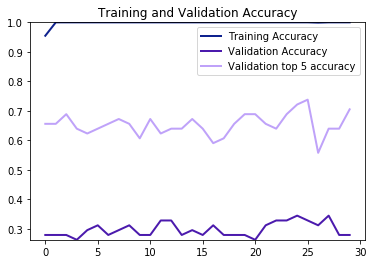

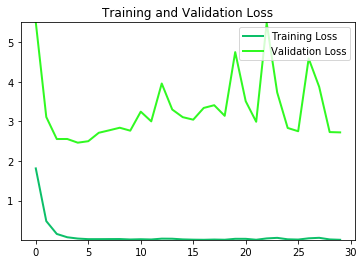

CNN Model results for {'noClasses': 18, 'trainEpochs': 30, 'denseSize': 128, 'denseL2': 0.01, 'dropoutRate': 0.4, 'class_weights': False, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000002001A070688>} lr=0.0010000000474974513


In [11]:
# select the training data set with the highest accuracy
best_data_model = None
best_hyper_params = None
best_history = None
best_checkpoint = None
if np.max(cnnHyperLookup.best_history['val_accuracy']) > np.max(cnnHyperLookupAug.best_history['val_accuracy']):
    print('Non augmented data performs better than image generator data')
    best_data_model = data_model
    best_hyper_params = cnnHyperLookup.best_params
    best_history = cnnHyperLookup.best_history
    best_checkpoint = cnnHyperLookup.best_checkpoint
else:
    print('Image generator data performs better than non augmented data')
    best_data_model = data_model_aug
    best_hyper_params = cnnHyperLookupAug.best_params
    best_history = cnnHyperLookupAug.best_history
    best_checkpoint = cnnHyperLookupAug.best_checkpoint

showTrainingHistory([(best_hyper_params, best_history)], True, True)

print("CNN Model results for {} lr={}".format(best_hyper_params,
                                              tf.keras.backend.eval(best_hyper_params['optimizer'].lr)))

##### CNN best model retrained
Reload the model using the saved weights in the hyper parameter search

In [12]:
# Open tensor board
#result = mm.TensorBoard.open()

# Load the model again using the epoch with the highest validation accuracy
cnn_hyper_params = best_hyper_params.copy()
cnn_hyper_params['trainEpochs'] = np.argmax(best_history['val_accuracy']) + 1

print("CNN Model using {} lr={}\nvalidation accuracy={}".format(cnn_hyper_params,
                                                               tf.keras.backend.eval(cnn_hyper_params['optimizer'].lr),
                                                               best_history['val_accuracy']))
cnn_model = CNNModel(**cnn_hyper_params)
# Load the best checkpoint found the in training
cnn_model.load_weights(best_checkpoint)

# Save the model to the disk
cnn_model.save_model()
# Optional load model
#cnn_model = mm.TensorModel.load()

CNN Model using {'noClasses': 18, 'trainEpochs': 25, 'denseSize': 128, 'denseL2': 0.01, 'dropoutRate': 0.4, 'class_weights': False, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000002001A070688>} lr=0.0010000000474974513
validation accuracy=[0.27868852, 0.27868852, 0.27868852, 0.26229507, 0.29508197, 0.3114754, 0.27868852, 0.29508197, 0.3114754, 0.27868852, 0.27868852, 0.32786885, 0.32786885, 0.27868852, 0.29508197, 0.27868852, 0.3114754, 0.27868852, 0.27868852, 0.27868852, 0.26229507, 0.3114754, 0.32786885, 0.32786885, 0.3442623, 0.32786885, 0.3114754, 0.3442623, 0.27868852, 0.27868852]


#### CNN Model metrics
Plot the confusion matrix and Receiver Operating Caracteristic curve for the best model.

The ROC curve will be plotted for each class as well as an micro averaged dotted one for all classes.

In a binary classification an AUC of 0.5 (blue diagonal line) means that the model has no discriminative capacity to differenciate between the 2 classes.

When AUC is 0.7, it means there is 70% chance that model will be able to distinguish between positive class and negative class.
Usually an AUC of 0.8 is considered good.

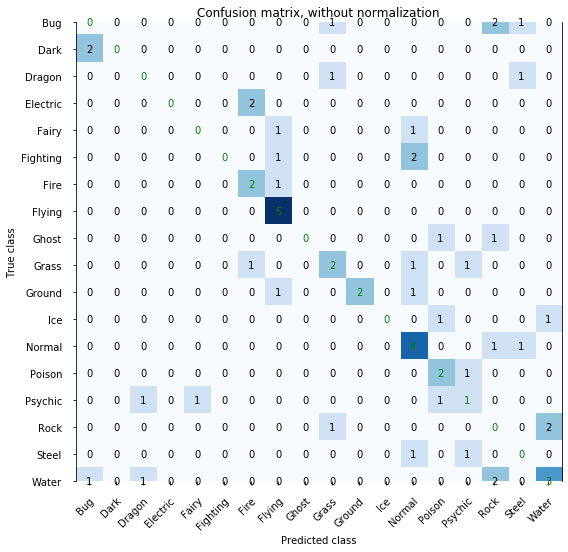

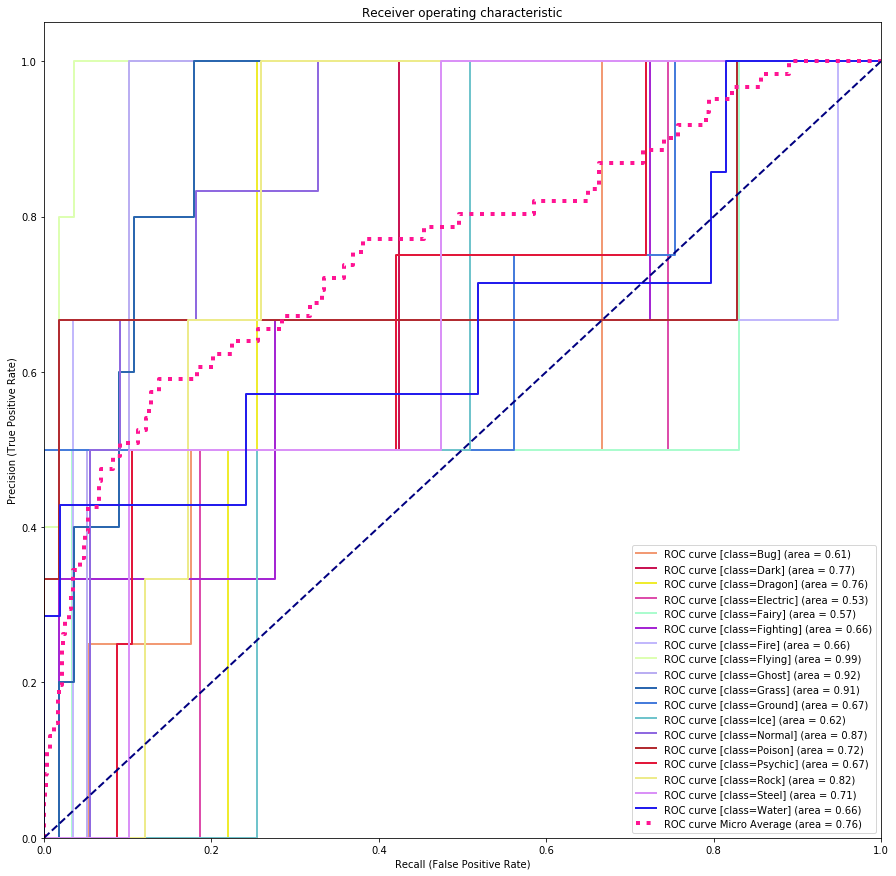

In [13]:
# Plot the confusion matrix and roc curve for the validation set
pred_targets, pred_scores = cnn_model.predict(data_model.validation_features)

mm.PlotBuilder().create_confusion_matrix(
    data_model.validation_target, pred_targets, data_set.classes).create_roc_curve_multiclass(
    data_model.validation_target, pred_scores, data_set.classes).show()

#### SVM model
Support Vector Machine model

Using sckit-learn libsvm implementation in dual form to be able to also use kernel on the data.

SVM models are binary classification models. To be used in a multi class clasification one-vs-all (n classfiers) or one-vs-one ($n*(n-1)/2$ classifiers) will be constructed and to do prediction majority voting will done for each classification.

The model has the following hyper parameters:
* softPenalty - how much you want to avoid misclassifying each training (high value means low support vectors size)
* svmType - if the classification should use one-vs-rest or one-vs-one
* kernel - a pair of kernel type (liniar, poly) and kernel features

In [14]:
from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import hinge_loss

class SVMModel(mm.SklearnModel):
    def __init__(self, **hyper_params):
        self.C = hyper_params.get('softPenalty', 0.1)
        self.svm_type = hyper_params.get('svmType', 'one-vs-rest')
        self.kernel, self.kernel_params = hyper_params.get('kernel', ('liniar', {}))

        # we are using the dual form of the SVM implemented in libsvm
        # this allows us to experiment with kernels
        model = svm.SVC(C=self.C, kernel=self.kernel, **self.kernel_params, class_weight='balanced')
        if model == 'one-vs-one':
            model = OneVsOneClassifier(model)
        else:
            model = OneVsRestClassifier(model)
    
        super(SVMModel, self).__init__(model)

    def train(self, data_model, log=False):
        assert len(data_model.train_features) < 2000, 'For larger databases consider using klearn.linear_model.LinearSVC or sklearn.linear_model.SGDClassifier'

        # Set the target classes in the libsvm model
        self._model.classes_ = data_model.classes

        self._model.fit(data_model.train_features, data_model.train_target)
        
        train_target, train_scores = self.predict(data_model.train_features)
        validation_target, validation_scores = self.predict(data_model.validation_features)

        return {
            'accuracy' : accuracy_score(data_model.train_target, train_target, normalize=True),
            'val_accuracy' : accuracy_score(data_model.validation_target, validation_target, normalize=True),
            'loss' : hinge_loss(data_model.train_target, train_scores, labels=data_model.classes),
            'val_loss' : hinge_loss(data_model.validation_target, validation_scores, labels=data_model.classes)
        }
    
    def predict(self, features):
        return self._model.predict(features), self._model.decision_function(features)

#### Data normalization
To be able to apply kernel methods data must be normalized.

First flatten the image to a feature vector on the dataset with no image generation.

Unit normalize the train data (0 mean, 1 std) and apply the train transformation to validation and test set

Extract the top 1000 features using f-statistic. We cannot use chi-squared statistic since some of the features will be negatve

In [15]:
# Recreate the numpy dataset that we will use in the mm.Model classes
# Since libSVM is using the dual form we don't want any generated images
# The feature data in this dataset will also be normalized an filtered
data_model_svm = mm.ModelDataSet(data_set)

# Normalize the features before proceeding
# Choose only the K best features from the f-statistic
data_model_svm = data_model_svm.flatten().normalize(mean=0, std=1).filter(max_features=1000)

##### Hyper parameter grid search
Search the hyper parameter space with both type of svm multi class aproaches as well as 3 differnet standard kernels

Select the model with the highest accuracy

In [16]:
# Perform a grid search lookup for the best hyperparameters
svmHyperLookup = mm.HyperParamsLookup(SVMModel(), lambda hist: hist['val_accuracy'])
svmHyperLookup.grid_search(data_model_svm, True,
                           svmType=['one-vs-all', 'one-vs-one'],
                           softPenalty=[0.1, 10, 100, 1e3, 1e4],
                           kernel=[('linear', {}),
                                   ('poly', {'degree' : 3}),
                                   ('rbf', {'gamma' : 'auto'})])

Hyperparameters: {'svmType': 'one-vs-all', 'softPenalty': 0.1, 'kernel': ('linear', {})}
Results: 0.14754098360655737
Hyperparameters: {'svmType': 'one-vs-all', 'softPenalty': 0.1, 'kernel': ('poly', {'degree': 3})}
Results: 0.09836065573770492
Hyperparameters: {'svmType': 'one-vs-all', 'softPenalty': 0.1, 'kernel': ('rbf', {'gamma': 'auto'})}
Results: 0.14754098360655737
Hyperparameters: {'svmType': 'one-vs-all', 'softPenalty': 10, 'kernel': ('linear', {})}
Results: 0.14754098360655737
Hyperparameters: {'svmType': 'one-vs-all', 'softPenalty': 10, 'kernel': ('poly', {'degree': 3})}
Results: 0.16393442622950818
Hyperparameters: {'svmType': 'one-vs-all', 'softPenalty': 10, 'kernel': ('rbf', {'gamma': 'auto'})}
Results: 0.18032786885245902
Hyperparameters: {'svmType': 'one-vs-all', 'softPenalty': 100, 'kernel': ('linear', {})}
Results: 0.14754098360655737
Hyperparameters: {'svmType': 'one-vs-all', 'softPenalty': 100, 'kernel': ('poly', {'degree': 3})}
Results: 0.14754098360655737
Hyperpar

##### Hyper parameter search model results
Plot the training and validation accuracy and loss for all the models

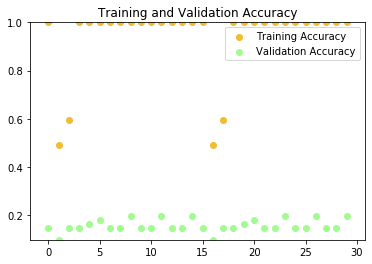

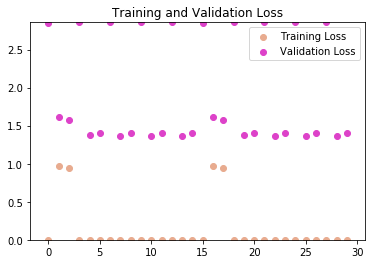

In [17]:
svm_hyper_params = svmHyperLookup.best_params

all_svm_history = {
    'accuracy' : [h['accuracy'] for _, h in svmHyperLookup.history],
    'val_accuracy' : [h['val_accuracy'] for _, h in svmHyperLookup.history],
    'loss' : [h['loss'] for _, h in svmHyperLookup.history],
    'val_loss' : [h['val_loss'] for _, h in svmHyperLookup.history]
}
showTrainingHistory([(_, all_svm_history)], True, False, True)

#### SVM best model metrics
Reload the best model with the selected hyper parameters

Plot the best model metrics: confusion matrix and ROC curve

Accuracy score on the training set: 1.0
Accuracy score on the validation set: 0.19672131147540983


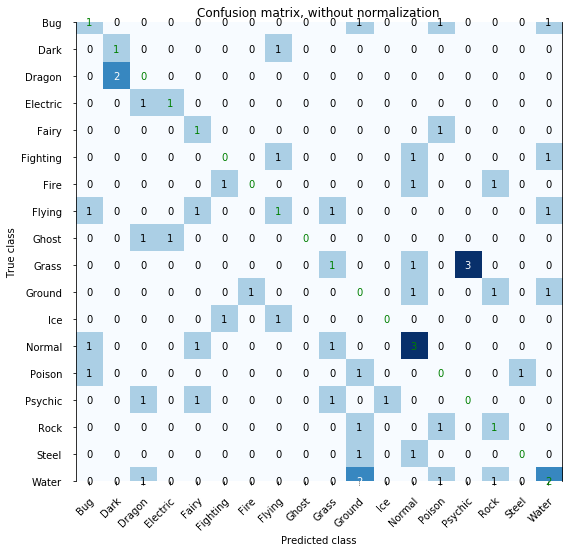

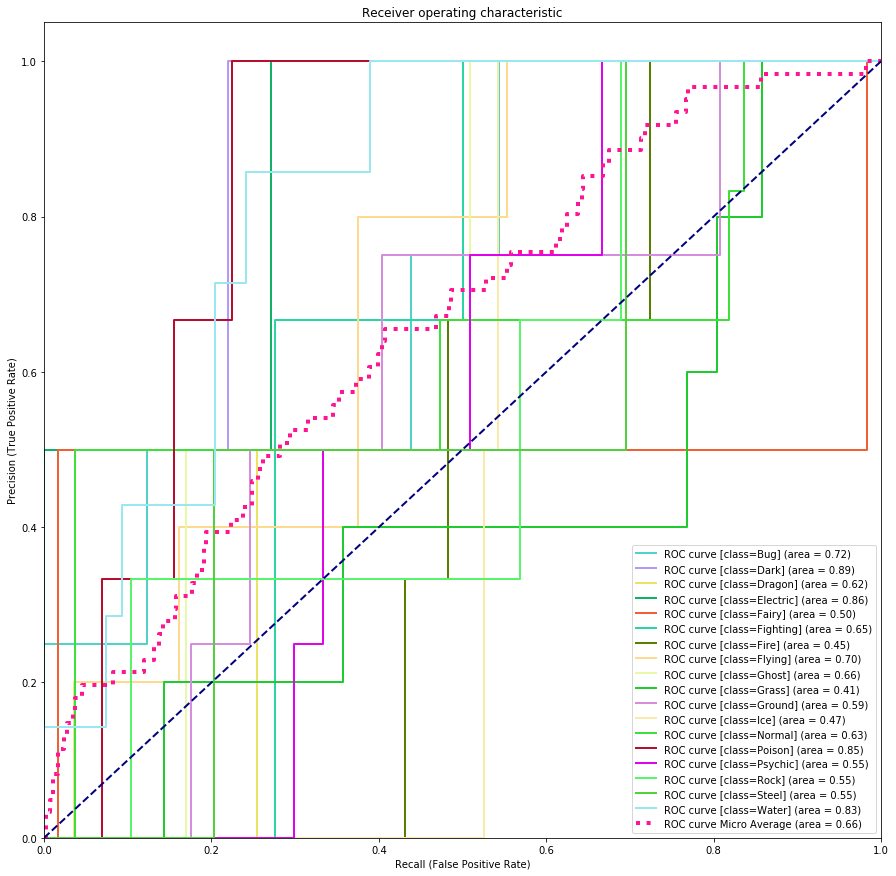

In [18]:
# reload the model using best hyperparameters and saved checkpoint
svm_model = SVMModel(**svmHyperLookup.best_params)
svm_model.load_weights(svmHyperLookup.best_checkpoint)

# Save the model to the disk
svm_model.save_model()

print("Accuracy score on the training set: {}".format(svmHyperLookup.best_history['accuracy']))
print("Accuracy score on the validation set: {}".format(svmHyperLookup.best_history['val_accuracy']))

pred_targets, pred_scores = svm_model.predict(data_model_svm.validation_features)

mm.PlotBuilder().create_confusion_matrix(
    data_model.validation_target, pred_targets, data_set.classes).create_roc_curve_multiclass(
    data_model.validation_target, pred_scores, data_set.classes).show()

#### Model selection
Run the 2 models on the *test set* and check accuracy and metrics

Plot the test class distribution.

Plot the confusion matrix of the CNN model vs SVM model. Notice what classes both models predicted correctly

CNN model test accuracy: 0.36508
hyper_params={'noClasses': 18, 'trainEpochs': 25, 'denseSize': 128, 'denseL2': 0.01, 'dropoutRate': 0.4, 'class_weights': False, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000002001A070688>} lr=0.0010000000474974513
SVM mean test accuracy: 0.19048
hyper_params={'svmType': 'one-vs-all', 'softPenalty': 100, 'kernel': ('rbf', {'gamma': 'auto'})}


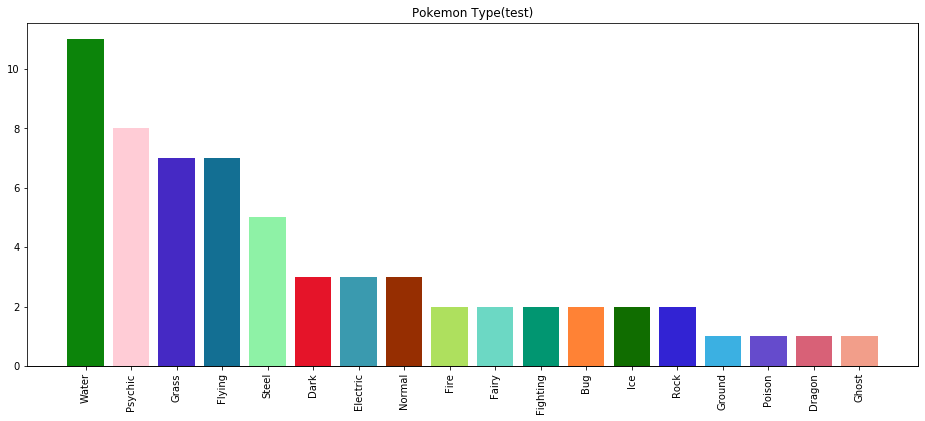

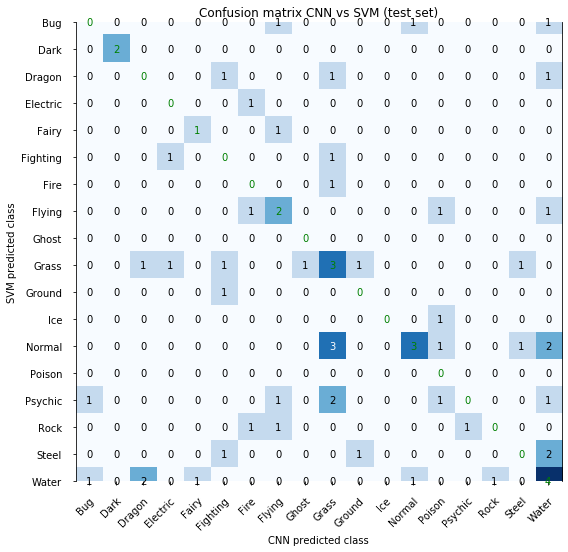

In [19]:
cnn_test_target, cnn_test_scores = cnn_model.predict(data_model.test_features)
svm_test_target, svm_test_scores = svm_model.predict(data_model_svm.test_features)

print("CNN model test accuracy: {0:.5f}\nhyper_params={1} lr={2}".format(
    accuracy_score(data_model.test_target, cnn_test_target, normalize=True), cnn_hyper_params,
    tf.keras.backend.eval(cnn_hyper_params['optimizer'].lr)))
print("SVM mean test accuracy: {0:.5f}\nhyper_params={1}".format(
    accuracy_score(data_model.test_target, svm_test_target, normalize=True), svm_hyper_params))

pb = mm.PlotBuilder().create_histograms([data_set.test_target], ['Pokemon Type(test)'])
pb.create_confusion_matrix(cnn_test_target, svm_test_target, data_set.classes,
                           title='Confusion matrix CNN vs SVM (test set)',
                           x_label='CNN predicted class', y_label='SVM predicted class')
pb.show()